# OpenCV solution for barcode detection

In [1]:
import numpy as np
import argparse
import cv2
import os
from matplotlib import pyplot as plt

In [2]:
test_path = "./CourseOCRTask3/Test/Images/"
train_path = "./CourseOCRTask3/Train/Images/"

In [3]:
img_names = os.listdir(train_path)
img_path = os.path.join(train_path, img_names[0])

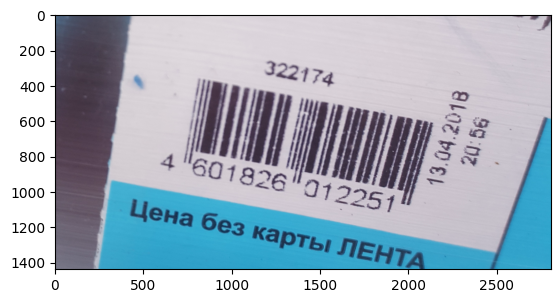

In [4]:
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image)

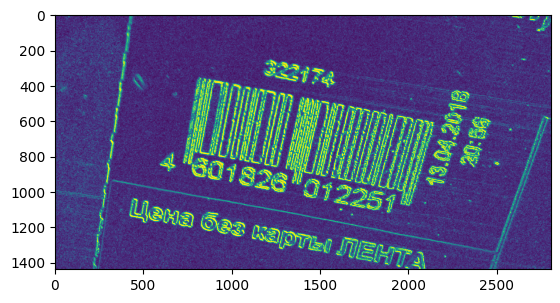

In [5]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
 
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.imshow(gradient)

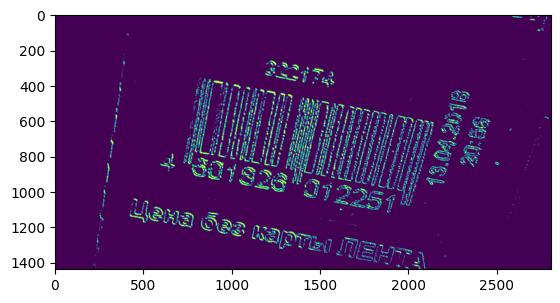

In [6]:
# blur and threshold the image
blurred = cv2.blur(gradient, (3, 3))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

plt.imshow(thresh)

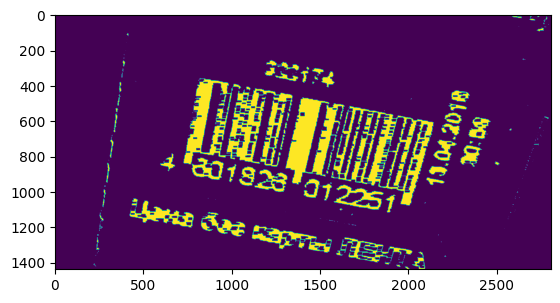

In [7]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed)

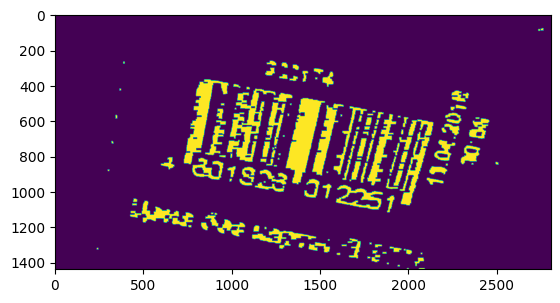

In [8]:
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 4)

plt.imshow(closed)

/tmp/ipykernel_3363149/1183823272.py:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))


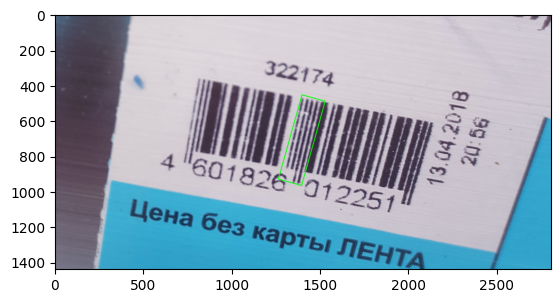

In [9]:
cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]

c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))

mask = np.zeros(image.shape[:2])
cv2.drawContours(mask, [box], -1, (1), -1)

# draw a bounding box arounded the detected barcode and display the
# image
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
# cv2.drawContours(image, [box1], -1, (0, 255, 0), 3)
plt.imshow(image)

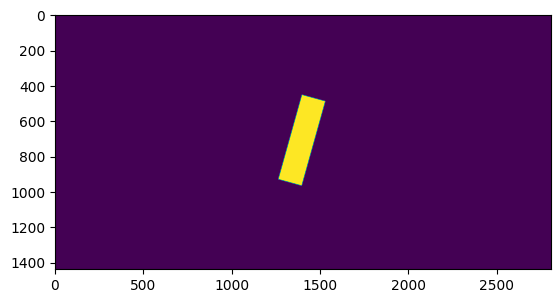

In [10]:
mask = np.zeros(image.shape[:2])
mask = cv2.drawContours(mask, [box], -1, (1), -1)
plt.imshow(mask*255)

Данный подход имеет неудовлетворительное качество

Попробуем распознавать штрихкоды классическими методами

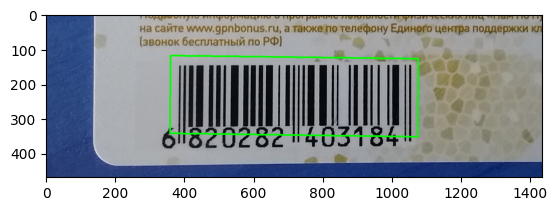

In [11]:
import pandas as pd

markup = pd.read_csv('./CourseOCRTask3/Train/markup.csv', encoding="utf-16", header=None)

item = markup.iloc[7]
coords = np.intp(item.values[2:10].reshape(4,2))
code = item[10]
image = cv2.imread(train_path + item[0]) 

coords = np.intp(item.values[2:10].reshape(4,2))
cv2.drawContours(image, [coords], -1, (0, 255, 0), 3)

plt.imshow(image)

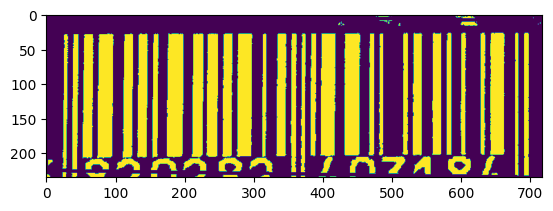

In [12]:
x1, y1, x2, y2, x3, y3, x4, y4 = coords.reshape(-1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = gray.shape

gray = gray[min(y1, y2): max(y3, y4), min(x1, x4) : max(x2, x3)]

(_, thresh) = cv2.threshold(gray, 115, 255, cv2.THRESH_BINARY)
inverted = 255 - thresh
plt.imshow(inverted)

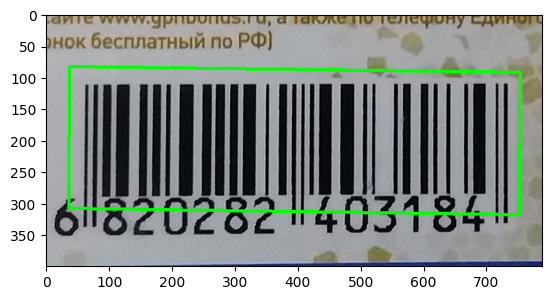

In [13]:
h, w = gray.shape

if h > w:
    scale_y = 0.05
    scale_x = 0.35
else:
    scale_y = 0.35
    scale_x = 0.05
    
cut_img = image[max(int(min(y1, y2) - scale_y*h), 0) : int(max(y3, y4) + scale_y*h), max(int(min(x1, x4) - scale_x*w), 0) : int(max(x2, x3) + scale_x*w)]
plt.imshow(cut_img)

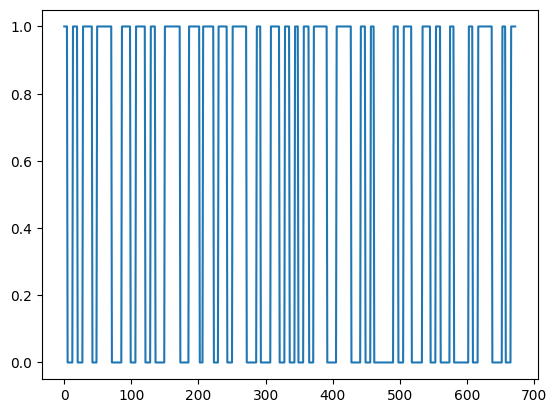

In [14]:
h, w = inverted.shape

hor_line = np.trim_zeros(inverted[h // 2] > 25).astype(int)

plt.plot(hor_line)
plt.show()

In [15]:
import numpy as np
from itertools import groupby

widths_line = [(key, len(list(group))) for key, group in groupby(hor_line)]

ones_width = (widths_line[0][1] + widths_line[-1][1]) / 2
zeros_width = (widths_line[1][1] + widths_line[-2][1]) / 2
res = ''

for (value, width) in widths_line:
    if value == 1:
        ones_count = np.round(width / ones_width).astype(int)
        res += '1'*ones_count
    elif value == 0:
        zeros_count = np.round(width / zeros_width).astype(int)
        res += '0'*zeros_count

print(res)
print(code)

101011011110011011010011110011101110110111100100110101010111001111001010000101100110100100010111100101
10101101110011011010011100110110110111001001101010101110011100101000010110011010010001011100101


Из-за искажений качество обработки таких изображений снижается

# Semantic segmentation barcode detection

In [16]:
import pandas as pd

markup = pd.read_csv('./CourseOCRTask3/Train/markup.csv', encoding="utf-16", header=None)
test_markup = pd.read_csv('./markup.csv', encoding="utf-16", header=None)
markup.head()

,0,1,2,3,4,5,6,7,8,9,10
0,fc272e4092ccb147a31e66bc1d10fbfb.png,3601514743345,538,248,1590,225,1597,663,532,676,1010101111000110101100110111001011001101000110...
1,8cde8cb1b54bca37c9347baf74157d22.png,7000001062307,372,433,360,1289,124,1293,147,431,1010001101010011100011010100111000110101100110...
2,70a9be0887eae17eabd70c8e607f963f.png,2250001407126,408,230,1224,229,1224,688,414,683,1010010011011000101001110100111000110101100110...
3,a029e49dff95a15d2cd396d8f62220c8.png,10101427156,335,149,1005,155,1005,438,335,447,1010001101001100100011010011001000110100110010...
4,82ff01909b6d215170dfc26c7be43074.png,2400745402226,469,237,1388,260,1392,712,464,696,1010100011000110101001110010001010001101110010...


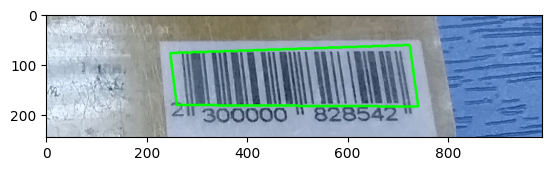

In [17]:
item = markup.iloc[27]
coords = np.intp(item.values[2:10].reshape(4,2))
code = item[10]
image = cv2.imread(train_path + item[0]) 

coords = np.intp(item.values[2:10].reshape(4,2))
cv2.drawContours(image, [coords], -1, (0, 255, 0), 3)

plt.imshow(image)

Создание маски

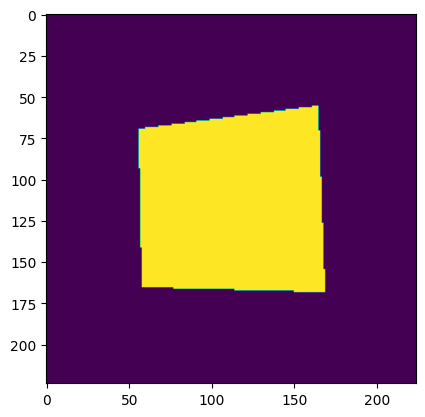

In [18]:
item = markup.iloc[27]
coords = np.intp(item.values[2:10].reshape(4,2))
image = cv2.imread(train_path + item[0]) 

mask = np.zeros(image.shape[:2])
W, H = image.shape[:2]

mask = cv2.resize(mask, (224, 224))
coords = coords / np.array([[H, W]]) * 224
cv2.drawContours(mask, [coords.astype(int)], -1, (1), -1)

#cv2.drawContours(mask, [coords], -1, (1), -1)
plt.imshow(mask)

Работа с данными

In [19]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [20]:
train_markup, val_markup = train_test_split(markup, test_size=0.2, random_state=42)

In [21]:
RGB_mean = [0.485, 0.456, 0.406]
RGB_std  = [0.229, 0.224, 0.225]

def get_train_transforms(img_size=224):
    train_transforms = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize((img_size, img_size)),
                                           transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return train_transforms


def get_test_transforms(img_size=224):
    test_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize((img_size, img_size)),
                                          transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return test_transforms


class BarCodeDataset(Dataset):
    def __init__(self, markup, img_path, img_size=224, transform='train'):
        self.markup = markup
        self.img_size = img_size
        self.img_path = img_path

        if transform == 'train':
            self.transform = get_train_transforms(img_size)
        elif transform == 'test':
            self.transform = get_test_transforms(img_size)

    def __len__(self):
        return len(self.markup)

    def __getitem__(self, idx):
        item = self.markup.iloc[idx]
        coords = np.intp(item.values[2:10].reshape(4,2))
        img = cv2.imread(self.img_path + item[0]) 
        
        mask = np.zeros(img.shape[:2])
        mask = cv2.drawContours(mask, [coords], -1, (1), -1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        mask = torch.tensor(mask)[None, :, :]
        img = self.transform(img)

        return img, mask

train_dataset = BarCodeDataset(train_markup, train_path, transform='train')
val_dataset = BarCodeDataset(val_markup, train_path, transform='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [22]:
print("Train samples: ", len(train_dataset))
print("Val samples: ", len(val_dataset))

Train samples:  6559
Val samples:  1640


Определим модель типа Unet с предобученным энкодером Resnet18

In [23]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [101]:
from course_ocr_t3.resnet18_unet import ResNetUNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(reduction='sum')
model = ResNetUNet(n_class=1).to(device)

In [32]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, device):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    train_mean_losses = []
    val_mean_losses = []
    best_loss = np.inf
    best_model = None
    num_iters = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        print(f'Start epoch {epoch}/{num_epochs}')
        for i, (inputs, targets) in tqdm(enumerate(train_loader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            output = model(inputs)
            loss = criterion(output, targets) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 10 == 0:
                print(f'{i}/{num_iters} loss {loss}')
            train_losses.append(loss.item())

        train_mean_loss = np.sum(train_losses)/len(train_losses)
        train_mean_losses.append(train_mean_loss)
        print(f"Epoch {epoch} train loss: {train_mean_loss}")

        model.eval()
        val_losses = []
        for i, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            with torch.no_grad():
                output = model(inputs)
            loss = criterion(output, targets) 
            val_losses.append(loss.item())
            
        val_mean_loss = np.sum(val_losses)/len(val_losses)
        val_mean_losses.append(val_mean_loss)
        print(f"Epoch {epoch} val loss: {val_mean_loss}")

        torch.save(model.state_dict(), f'./models/model_{np.round(val_mean_loss, 2)}_epoch{epoch}.pt')
        if val_mean_loss < best_loss:
            torch.save(model.state_dict(), f'./models/best_model.pt')
            best_model = model
            best_loss = val_mean_loss

    return train_mean_losses, val_mean_losses, best_model

In [103]:
train_mean_losses, val_mean_losses, best_model = train_model(model, train_loader, val_loader, num_epochs=10, criterion=criterion, device=device)

Start epoch 0/10


1it [00:04,  4.31s/it]

0/205 loss 1088734.5390768037


101it [06:15,  3.76s/it]

100/205 loss 101849.68577007478


201it [12:33,  3.65s/it]

200/205 loss 97981.31865974833


205it [12:47,  3.74s/it]


Epoch 0 train loss: 164595.9325094263
Epoch 0 val loss: 195614.48657007437
Start epoch 1/10


1it [00:02,  2.75s/it]

0/205 loss 86747.77553410047


101it [05:20,  3.36s/it]

100/205 loss 84238.75298797533


201it [11:01,  3.71s/it]

200/205 loss 109419.73771096299


205it [11:17,  3.30s/it]


Epoch 1 train loss: 71496.42466257907
Epoch 1 val loss: 132766.86799574413
Start epoch 2/10


1it [00:03,  3.65s/it]

0/205 loss 69945.40510489086


101it [06:11,  4.32s/it]

100/205 loss 63920.4323979491


201it [13:48,  5.07s/it]

200/205 loss 63577.06548485659


205it [14:04,  4.12s/it]


Epoch 2 train loss: 62871.98090023676
Epoch 2 val loss: 151736.11968922775
Start epoch 3/10


1it [00:03,  3.66s/it]

0/205 loss 69297.32215360794


12it [00:41,  3.44s/it]


KeyboardInterrupt: 

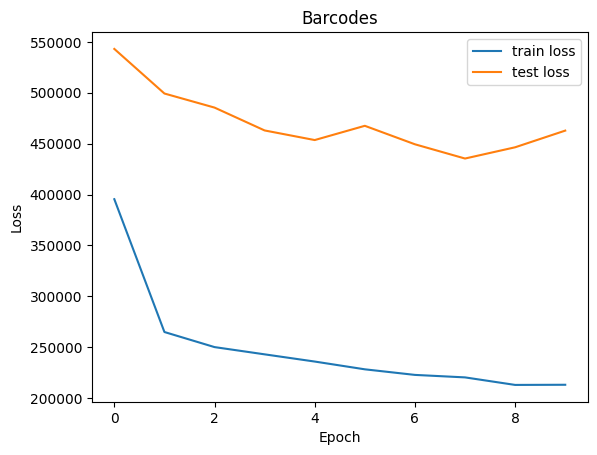

In [147]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

show_train_plots(train_mean_losses, val_mean_losses, 'Barcodes')

Визуализация результатов

In [233]:
def visualize_results(model, img, show=True, thresh=0.4):
    test_transforms = get_test_transforms()
    tensor_img = test_transforms(img)[None]
    w, h, _ = img.shape
    model.eval()
    with torch.no_grad():
        tensor_img = tensor_img.to(device)
        output_map = torch.sigmoid(model(tensor_img))
        output_map = torch.nn.functional.interpolate(output_map, size=(w, h)).cpu()
    output_map = output_map[0].permute(1, 2, 0).numpy()
    output_map = np.array((output_map > thresh) * 255, np.uint8)  

    if show:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(output_map)
        ax[1].imshow(img)

    return output_map

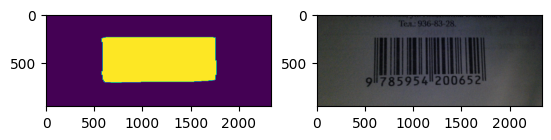

In [247]:
img_names = os.listdir(test_path)
img_path = os.path.join(test_path, img_names[1])
image = cv2.imread(img_path)

map = visualize_results(model, image)

Находим наиболее подходящий прямоугольник для найденной HeatMap

/tmp/ipykernel_536693/1509886561.py:5: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rect))


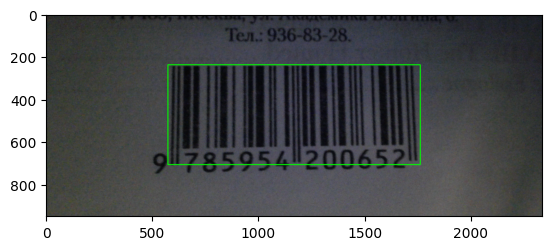

In [248]:
cnts, hierarchy = cv2.findContours(map.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

rect = cv2.minAreaRect(c)
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(image, [box], -1, (0, 255, 0), 3)

plt.imshow(image)

In [236]:
def get_barcode_coords(img_path, model):
    image = cv2.imread(img_path)
    map = visualize_results(model, image, show=False)
    cnts, hierarchy = cv2.findContours(map.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    rect = cv2.minAreaRect(c)
    box = np.intp(cv2.boxPoints(rect))

    return box.reshape(-1)

In [237]:
box = get_barcode_coords(img_path, model)
box

array([ 679, 1215, 2393, 1163, 2464, 3505,  750, 3557])

Запишем координаты в ответ

In [238]:
my_answer = pd.read_csv('./answer_example.csv', encoding="utf-16", header=None)
my_answer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,2005003708814,569,485,1644,452,1707,1335,583,1356,1010001101000110101110010100111000110101000010...
1,f9bf5d96a0cf5d64aac4eb5806554224.png,8594015301013,686,446,1833,528,1747,1338,611,1117,1010110001001011101000110100111011001101100010...
2,a154b624c06072da1a01c97ebc3894c1.png,4607016245676,536,483,1552,313,1608,767,620,939,1010101111010011101110110001101011001100001010...
3,749003091876fc58be69db54bbaae8f1.png,4602824019426,522,270,1541,229,1566,636,537,688,1010101111010011100100110110111001101100111010...
4,560ca4ac1260313eb5979140c4f9ef31.png,9785947231250,553,248,1648,265,1637,745,549,736,1010111011000100101110010001011001110101110110...


In [239]:
for i, img_name in tqdm(enumerate(my_answer[0])):
    my_answer.at[i, 1] = int('1' * 13)
    my_answer.at[i, 10] = int('1' * 95)

    img_path = os.path.join(test_path, img_name)
    coords = get_barcode_coords(img_path, model)
    my_answer.iloc[[i], 2:10] = coords

100it [00:16,  6.18it/s]


In [240]:
my_answer.head()

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,1111111111111,557,452,1716,452,1716,1346,557,1346,1111111111111111111111111111111111111111111111...
1,f9bf5d96a0cf5d64aac4eb5806554224.png,1111111111111,590,1208,634,419,1845,486,1802,1275,1111111111111111111111111111111111111111111111...
2,a154b624c06072da1a01c97ebc3894c1.png,1111111111111,529,446,1562,298,1633,793,599,941,1111111111111111111111111111111111111111111111...
3,749003091876fc58be69db54bbaae8f1.png,1111111111111,510,262,1565,222,1580,638,526,678,1111111111111111111111111111111111111111111111...
4,560ca4ac1260313eb5979140c4f9ef31.png,1111111111111,550,249,1647,249,1647,744,550,744,1111111111111111111111111111111111111111111111...


In [241]:
my_answer.to_csv('answer.csv', encoding='utf-16', header=None, index=False)

In [242]:
answer = pd.read_csv('./answer.csv', encoding="utf-16", header=None)

In [243]:
!python3 ./course_ocr_t3/evaluate.py

Checking answer (/home/syrovatkins/course_ocr/task3/answer.csv) against markup(/home/syrovatkins/course_ocr/task3/markup.csv)
recognition_accuracy=0.0
detection_result=0.99
score=0.3465


# Barcode decode using ViT

In [24]:
filtered_markup = markup[markup[1].astype(str).map(len) == 13]
filtered_train_markup, filtered_val_markup = train_test_split(filtered_markup, test_size=0.1, random_state=42)

In [25]:
values_train_tensors = [torch.tensor(list(map(int, str(i)))) for i in filtered_train_markup[1].values]
values_val_tensors = [torch.tensor(list(map(int, str(i)))) for i in filtered_val_markup[1].values]

In [108]:
RGB_mean = [0.485, 0.456, 0.406]
RGB_std  = [0.229, 0.224, 0.225]


def get_train_transforms(img_size=(16, 192)):
    train_transforms = transforms.Compose([transforms.ToTensor(),
                                           transforms.Resize(img_size),
                                           transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return train_transforms


def get_test_transforms(img_size=(16, 192)):
    test_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize(img_size),
                                          transforms.Normalize(mean=RGB_mean, std=RGB_std)])
    return test_transforms


class BarCodeRecognitionDataset(Dataset):
    def __init__(self, markup, img_path, targets, img_size=(16, 192), transform='train'):
        self.markup = markup
        self.targets = targets
        self.img_size = img_size
        self.img_path = img_path

        if transform == 'train':
            self.transform = get_train_transforms(img_size)
        elif transform == 'test':
            self.transform = get_test_transforms(img_size)

    def __len__(self):
        return len(self.markup)

    def __getitem__(self, idx):
        item = self.markup.iloc[idx]
        x1, y1, x2, y2, x3, y3, x4, y4 = np.intp(item.values[2:10])
        x_s = [x1, x2, x3, x4]
        y_s = [y1, y2, y3, y4]
        
        barcode_value = self.targets[idx]
        img = cv2.imread(self.img_path + item[0]) 
        
        min_y = int(np.clip(np.min(y_s) - img.shape[0] * 0.15, 0, img.shape[0] - 1))
        max_y = int(np.clip(np.max(y_s) + img.shape[0] * 0.15, 0, img.shape[0] - 1))

        min_x = int(np.clip(np.min(x_s) - img.shape[1] * 0.15, 0, img.shape[1] - 1))
        max_x = int(np.clip(np.max(x_s) + img.shape[1] * 0.15, 0, img.shape[1] - 1))

        img = img[min_y:max_y, min_x:max_x]
        if img.shape[0] > img.shape[1]:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

        img = self.transform(img)

        return img, barcode_value[1:]

train_dataset = BarCodeRecognitionDataset(filtered_train_markup, train_path, values_train_tensors, transform='train')
val_dataset = BarCodeRecognitionDataset(filtered_val_markup, train_path, values_val_tensors, transform='test')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=8)

In [109]:
print("Train samples: ", len(train_dataset))
print("Val samples: ", len(val_dataset))

Train samples:  7343
Val samples:  816


Определим модель

In [110]:
class BarCodeDecoder(nn.Module):
    def __init__(self, ):
        super(BarCodeDecoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.lstm = nn.LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.max_pool2d(self.bn1(F.relu(self.conv1(x))), 2)
        x = F.max_pool2d(self.bn2(F.relu(self.conv2(x))), 2)
        x = F.max_pool2d(self.bn3(F.relu(self.conv3(x))), 2)
        x = F.max_pool2d(self.bn4(F.relu(self.conv4(x))), 2)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        x = x.permute([0, 2, 1])
        x, _ = self.lstm(x)
        out = self.fc(F.relu(x))  
        
        return out.permute([0, 2, 1])

In [105]:
import torch.nn as nn
import torch.nn.functional as F

class BidirectionalLSTM(nn.Module):
    # Inputs hidden units Out
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

class CRNN(nn.Module):
    def __init__(self, nc, nclass, nh, seq_lenght, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()

        ks = [3, 3, 3, 3, 3, 3, 3, 3]
        ps = [1, 1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1, 1]
        nm = [16, 32, 64, 64, 64, 128, 128, 128]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d(2, 2))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d(2, 2))  # 512x2x16
        convRelu(6)
        cnn.add_module('pooling{0}'.format(4),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(7, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(128, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))
        self.linear = nn.Linear(10, seq_lenght)

    def forward(self, input):

        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        conv = conv.squeeze(2)
        conv = self.linear(conv)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        output = self.rnn(conv).permute(1, 2, 0)

        return output

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model
# model = CRNN(3, 10, 128, 13).to(device)
model = BarCodeDecoder().to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
train_mean_losses, val_mean_losses, best_model = train_model(model, train_loader, val_loader, num_epochs=5, criterion=criterion, device=device)

Start epoch 0/5


1it [04:44, 284.48s/it]

0/58 loss 2.3124072551727295


10it [13:12, 74.07s/it]

10/58 loss 2.1895687580108643


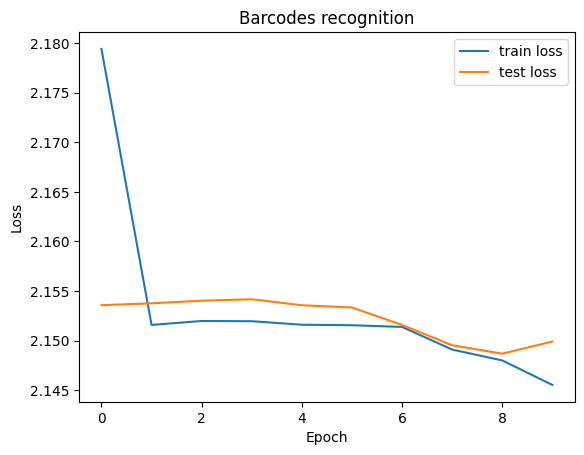

In [42]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

show_train_plots(train_mean_losses, val_mean_losses, 'Barcodes recognition')

In [50]:
def visualize_results(model, img, show=True):
    test_transforms = get_test_transforms()
    tensor_img = test_transforms(img)[None]
    w, h, _ = img.shape
    model.eval()
    with torch.no_grad():
        tensor_img = tensor_img.to(device)
        output = torch.softmax(model(tensor_img), dim=1)
        output = torch.argmax(output, dim=1) 

    if show:
        plt.imshow(img)
        print(output)

    return output

In [51]:
answer = pd.read_csv('./answer.csv', encoding="utf-16", header=None)
answer

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,1111111111111,557,452,1716,452,1716,1346,557,1346,1111111111111111111111111111111111111111111111...
1,f9bf5d96a0cf5d64aac4eb5806554224.png,1111111111111,590,1208,634,419,1845,486,1802,1275,1111111111111111111111111111111111111111111111...
2,a154b624c06072da1a01c97ebc3894c1.png,1111111111111,529,446,1562,298,1633,793,599,941,1111111111111111111111111111111111111111111111...
3,749003091876fc58be69db54bbaae8f1.png,1111111111111,510,262,1565,222,1580,638,526,678,1111111111111111111111111111111111111111111111...
4,560ca4ac1260313eb5979140c4f9ef31.png,1111111111111,550,249,1647,249,1647,744,550,744,1111111111111111111111111111111111111111111111...
...,...,...,...,...,...,...,...,...,...,...,...
95,bf547f52301ee51df5faf1a6dc678740.png,1111111111111,758,211,2236,163,2301,2160,823,2208,1111111111111111111111111111111111111111111111...
96,d7d7c5f9109aa31aff407eeab054bfc7.png,1111111111111,435,617,1262,610,1274,2097,447,2104,1111111111111111111111111111111111111111111111...
97,d6230eb6dc78728c09024eb674c427ef.png,1111111111111,232,495,676,466,741,1469,297,1498,1111111111111111111111111111111111111111111111...
98,f534d421c7e36d6133a5e9031a7e2dd5.png,1111111111111,223,474,646,468,665,1977,242,1983,1111111111111111111111111111111111111111111111...


tensor([[6, 0, 3, 9, 2, 2, 5, 6, 7, 7, 2, 8]], device='cuda:0')


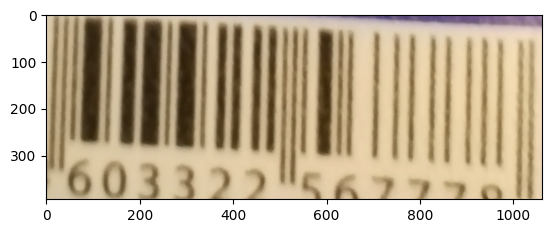

In [67]:
item = answer.iloc[27]
x1, y1, x2, y2, x3, y3, x4, y4 = np.intp(item.values[2:10])

img = cv2.imread(test_path + item[0]) 

x_s = [x1, x2, x3, x4]
y_s = [y1, y2, y3, y4]
img = img[np.min(y_s):np.max(y_s), np.min(x_s):np.max(x_s)]
if img.shape[0] > img.shape[1]:
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

output = visualize_results(model, img)

In [ ]:
# model.load_state_dict(torch.load('./rec_models/best_model.pt'))